In [1]:
%%HTML
<link rel="stylesheet" href="custom.css">

## <span style="color:blue"> Before you start, if you run on colab </span>...
On colab, each notebook runs on its own environment, so you first need to run the following cell in order to download all the repository and to run the notebook part1.

**Advice:** If it is not done, don't forget to change the Runtime type into "GPU" so to speed up the computations.

## <span style="color:blue"> Before you start, if you run on kaggle </span>...
You first need to **turn internet on** (available in the Settings in the right panel). To do that you need to have a verified kaggle account.
On kaggle, each notebook runs on its own environment, so you first need to run the following cell in order to download all the repository and to run the notebook part1.


**Warning:** The cell below re-run the notebook part 1, it can take a couple of minutes.


In [2]:
# First run configuration for colab & kaggle
import sys, os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') != ''

if IN_COLAB or IN_KAGGLE:
    print('Colab detected' if IN_COLAB else 'Kaggle detected')
    
    if os.path.isdir('2022-mooc-ecmwf-bocquet-brajard'):
      %cd 2022-mooc-ecmwf-bocquet-brajard/
    if not os.path.isfile('mooc_ecmwf_bocquet_brajard_part1.ipynb'):
      
      # Clone the git repository
      !git clone https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard.git

      # Make the repository as working directory
      %cd 2022-mooc-ecmwf-bocquet-brajard/

    if not os.path.isfile('Output/xt.npy'):

      # Run the notebook part 1
      %run mooc_ecmwf_bocquet_brajard_part1.ipynb

Kaggle detected


# <span style="color:maroon"> Data assimilation, machine learning, and dynamical systems - Part II  </span>
#### Marc Bocquet¹ [marc.bocquet@enpc.fr](mailto:marc.bocquet@enpc.fr) and Julien Brajard² [julien.brajard@nersc.no](mailto:julien.brajard@nersc.no)
#### (1) CEREA, École des Ponts et EdF R&D, Île-de-France, France
#### (2) Nansen Center (NERSC), Bergen, Norway

During this session, we will discover some connections between data assimilation and deep learning when applied to dynamical systems.

# <span style="color:teal"> Second step: Learn the model error through machine learning.</span>

In this notebook, we will use the output of data assimilation to train a neural network into predicting the model error. The procedure is the following:
1. The **analysis** $x^{\rm a}_k$ is used as the best possible estimate from the truth at time step $t_k$.
2. The physical model is used to produced a **forecast** $x^{\rm f}_{k}$ using the analysis $x^{\rm a}_{k-1}$ as initial conditions.
3. For each time $t_k$, the difference between the forecast and the analysis is used to estimate the **model error** $\mathrm{err}_k = x^{\rm a}_k - x^{\rm f}_k$. Note that this value is called **analysis increment** in the context of data assimilation.
4. A **neural network** taking $x^{\rm a}_{k-1}$ as an input is trained, supervised by the data $\mathrm{err}_k$
<p align = "center">
<img src="https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard/blob/colab/Figures/scheme-err.png?raw=1" alt="Model error estimation" width="600"/>
</p>

## <span style="color:blue"> I. Check the result of data assimilation </span>
Before training the neural network, as it is recommended for *any* machine learning process, we have a look at the data.


In [3]:
# Import standard modules
import pathlib
import json
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
from pickle import dump


from tensorflow.keras.layers import Input, Conv1D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import Model
import tensorflow as tf
from utils import tqdm_callback

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from model.neuralnet import Periodic1DPadding

# Load dataset lengths
with open('./Nt.cfg', 'r') as f:
    Nt = json.load(f)

# Directory for results
outputdir = pathlib.Path("./Output")

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

First, we load the result of the data assimilation, the so-called **analysis**. We also load the truth to plot some diagnostics.

In [4]:
# Load the analysis:
xa = np.load(outputdir / 'xa.npy')

# Load the slice of the truth corresponding to the analysis
xt = np.load(outputdir / 'xt.npy')[:Nt['train']]

print(f'Shape (number of samples, number of features) of the truth: {xt.shape}')
print(f'Shape (number of samples, number of features) of the analysis: {xa.shape}')

Shape (number of samples, number of features) of the truth: (5000, 40)
Shape (number of samples, number of features) of the analysis: (5000, 40)


Here we define the physical model so as to compute the forecast:

In [5]:
# Check that the parameters of L96 are the same as in the first notebook.
from model.lorenz96 import l96
Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)

In the standard configuration, the best estimate we have from the system is the analysis. 

Here, as we know the truth, we can choose to use the true value of the L96 variable instead of the analysis.  Then, the data are **perfect**: there is no error due to the observation error, the observation sampling, and the data assimilation process. It is an ideal case, but it cannot be achieved for most realistic systems.

If you want to do the test with perfect data, you just have to uncomment the line ```learning = 'truth'```. It is expected to be much easier to learn the model error as there is not additional noise.



In [6]:
learning = 'analysis'
#learning = 'truth'
if learning == 'analysis':
    x = xa
else:
     x = xt #learn on the true error

In [7]:
# Compute the forecast of the physical model
xf = x + phi(x)

# Compute the model error
err = x[1:] - xf[:-1]

Now, we will compute and plot a diagnostic of the data assimilation. This diagnostic use the truth to evaluate the results, let's highlight that in a "real-world" case, the truth is not known and such diagnostics cannot be computed the same way. In such cases the truth is not known, observations can also be used, which come with additional challenges out of the scope of this module.

In [8]:
# One utility function to compute scatter plots
def scatter_plot(x,y,ax=None):
    x, y = x.ravel(), y.ravel()
    ax = sns.regplot(x=x, y=y, ax=ax)
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y, squared=False)
    ax.set_title(f'R2={r2:.2f}, RMSE={mse:.2e}')
    return ax

The RMSE in time is defined as
$$
\mathrm{RMSE}(k) = \sqrt{\frac{1}{N_x} \sum_{n=1}^{N_x} \left( x^{\rm t}_n - x^{\rm a}_n \right)^2},
$$
where $k$ is the index for the time, $n$ is the space index, $x^{\rm t}_n$ is the true value and $x^{\rm a}_n$ is the analysis (the result of the data assimilation).

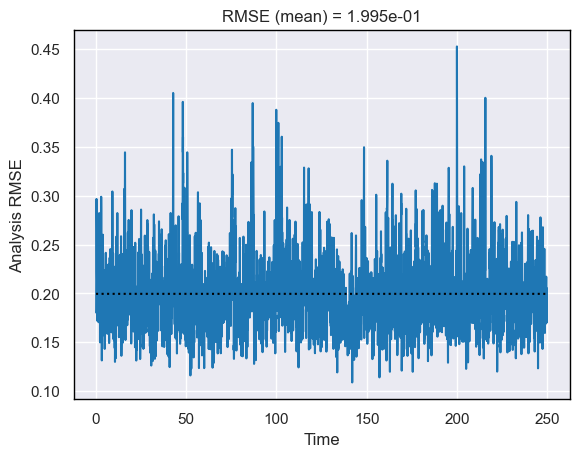

In [9]:
rmse_time = np.sqrt(np.mean(np.square(xt-xa),axis=1))
plt.plot(dt*np.arange(rmse_time.shape[0]),rmse_time)
plt.plot(dt*np.arange(rmse_time.shape[0]), rmse_time.mean()*np.ones(rmse_time.shape[0]), ':k' )
plt.xlabel('Time');
plt.ylabel('Analysis RMSE');
plt.title(f'RMSE (mean) = {rmse_time.mean():.3e}');

The dotted line is the mean of the RMSE, we should retrieve the same value as in part one of this session (around 0.2). We observe that, despite a couple of peaks, the RMSE is stable in time, which is a necessary condition. Indeed, in the following, we assume that the analysis is stationary, which means that its statistical properties do not depend on the time (for example there is no trend in the error).

To have a sense of the accuracy of the analysis compared with the truth, we can also represent the analysis in the form of a scatter plot.


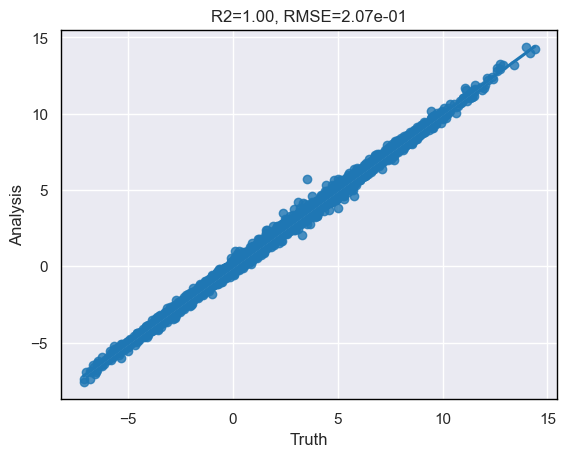

In [10]:
ax = scatter_plot (xt[:,20], xa[:,20])
ax.set_xlabel('Truth')
ax.set_ylabel('Analysis');
plt.savefig('figures/scatter_analysis')

It appears clearly that the analysis is close to the true value, so the assumption that "The analysis is the best estimate we have of the truth" is reasonable.
Note that the RMSE can be a bit different as it is the total RMSE for the variable 20, chosen arbitrary and not the mean RMSE in time for all the variables. 

## <span style="color:blue"> II. Build the neural network.</span>
It is now time to define the neural network. We are using the Keras API of TensorFlow https://www.tensorflow.org/api_docs/python/tf/keras, the approach is of course also applicable using any deep-learning framework such as Pytorch https://pytorch.org/

We initialize random generators so the notebooks are fully reproducible. Several aspects are based on random processes:
- The initialization of the weights of the neural network
- The batch-sized chunk presented to the neural during the training are randomly shuffled at each epoch.


In [11]:
import random, os
seed = 1980
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

We define the function that builds the neural net model as the form of a convolutional neural network. The function takes several input arguments:
- `archi`: specify the hidden layers of the neural network as a form of a list of triplets. Each element of the list represents a hidden layer. A triplet is in the form of  `(nunits, kernelsize, activation)` where:
    - `nunits` is the number of units (neurons) on the layer
    - `kernelsize` is the kernel size of the convolution 
    - `activation` is the activation function
- `Nx`: is the spatial size of the problem (in our case: $N_x=40$)
- `reg`: is the L2 weight regularization of the output layer (default=1e-5). Can be set to zeros if you don't want to use regularization
- `batchlayer`: Possibility to add batchnormalization before hidden layer (default is None). It is represented as a set of indexes. For example, specify `{0,2}` to have batchnormalization before the first and third hidden layers.

In [12]:
def buildmodel(archi, Nx=40, reg=1e-5, batchlayer={}):

    # Input Layer:
    inputs = Input(shape=(Nx,1))
    
    # Pre-processing layer to account for the periodicity of the space:
    border = int(np.sum(np.array([kern//2 for nfil,kern,activ in archi])))
    x = Periodic1DPadding(padding_size=border)(inputs)
    
    # BatchNormalization layer
    x = BatchNormalization()(x)
    
    # Definition of the hidden layers
    for i, (nfil, kern, activ) in enumerate(archi):
        if i in batchlayer:
            x = BatchNormalization()(x)
        x = Conv1D(nfil, kern, activation=activ)(x)
        
    # Ouput layer (with optional regularization)
    output= Conv1D(1,1,activation='linear', kernel_regularizer=regularizers.l2(reg))(x)
    return Model(inputs,output)


In [13]:
#We propose here a default neural network setting but feel free to play with the neural net characteristics

archi = [(40, 7, 'tanh'),
         (20, 5, 'tanh'),
         (20, 1, 'tanh')
        ]
model = buildmodel(archi)

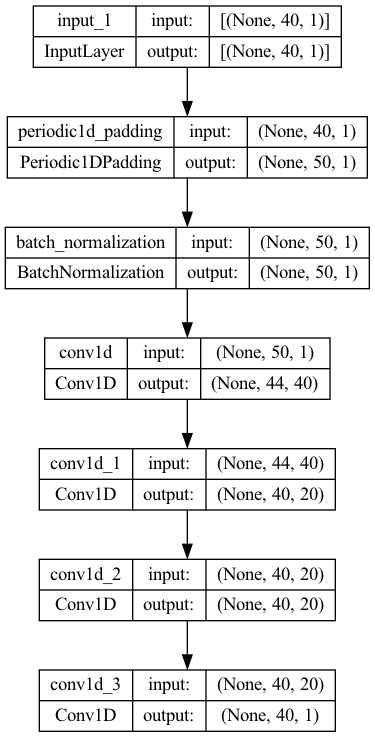

In [14]:
# We can plot the architecture of our model
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
# We can also have a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 periodic1d_padding (Periodi  (None, 50, 1)            0         
 c1DPadding)                                                     
                                                                 
 batch_normalization (BatchN  (None, 50, 1)            4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 44, 40)            320       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 20)            4020      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 20)            420   

## <span style="color:blue"> III. Train the neural network.</span>
In this section, the neural network defined previously is trained. The dataset is divided into two parts: the training set used to optimize the weights, and the validation set to follow the evolution of the metric and avoid overfitting.

The training/validation is defined with two parameters:
- `frac_train` (default: 0.8): Fraction of the data selected as training data, the rest is used for validation
- `valend` (default: True): Flag to indicate if the validation is taken at the end of the analysis (if True) or at the beginning of the analysis (if False)

In [16]:
frac_train = .8
valend = True

In [17]:
# Split in train/validation
X = x[:-1]
y = err

itrain = int(frac_train*X.shape[0])
if valend == True:
    Xtrain, ytrain = X[:itrain], y[:itrain]
    Xval, yval = X[itrain:], y[itrain:]
else:
    Xtrain, ytrain = X[-itrain:], y[-itrain:]
    Xval, yval = X[:-itrain], y[:-itrain]
print(f'Total number of samples: {X.shape[0]}')
print(f'Number of training samples: {Xtrain.shape[0]}')
print(f'Number of validation samples: {Xval.shape[0]}')
print(f'Number of input features: {Xval.shape[1]}')

Total number of samples: 4999
Number of training samples: 3999
Number of validation samples: 1000
Number of input features: 40


The data presented as an input or output are standardised to facilitate the training. Important: the scaling factors (mean and standard deviation) are computed on the training set only, and the same values will be applied for validation and testing.

In [18]:
scaler_x = StandardScaler().fit(Xtrain)
scaler_y = StandardScaler().fit(ytrain)


The model is compiled as required by the keras API. The loss function optimized is the mean square error and the chosen optimiser is `Adam` (see https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile for more details)

In [19]:
model.compile(loss='mse', optimizer='adam')

To fit the model to the data, we specify the number of epochs. The evolution of the metrics during the training is saved in the `history` variable.

In [20]:
num_epochs = 500

# We define a callback to follow the evolution of the training
callbacks = [ tqdm_callback(num_epochs, 'NN training') ]

history = model.fit(scaler_x.transform(Xtrain), scaler_y.transform(ytrain), 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data = (scaler_x.transform(Xval), scaler_y.transform(yval)),
                    verbose=0, callbacks=callbacks)

NN training:   0%|          | 0/500 [00:00<?, ?it/s]

2023-03-01 11:38:57.389621: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


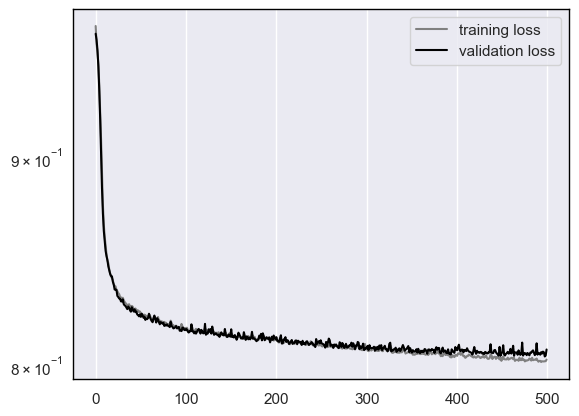

In [21]:
# Plot the learning curve
plt.semilogy(history.history['loss'], color='gray', label='training loss')
plt.semilogy(history.history['val_loss'], color='black', label='validation loss')
plt.legend()
plt.savefig('figures/learning_curve')


We expect both validation and training loss to decrease. If the validation stabilise or increase while the training loss continues to decrease, it means that the neural network overfits on the training set. In that case, the training can be stopped earlier by reducing the number of epochs (it is called "Early stopping").

In [22]:
# Save the model and the standardisation coefficients
if learning=='analysis':
    name = 'damodel'
else:
    name = 'true_model'
model.save(outputdir / f'{name}_nn')
dump(scaler_x, open(outputdir / f'{name}_scalerx', 'wb'))
dump(scaler_y, open(outputdir / f'{name}_scalery', 'wb'))

INFO:tensorflow:Assets written to: Output/damodel_nn/assets


INFO:tensorflow:Assets written to: Output/damodel_nn/assets


## <span style="color:blue"> IV. Validate the model (offline).</span>
In this section, we apply the neural network to the validation dataset and see how well the neural net has been trained.

In [23]:
ypredict = scaler_y.inverse_transform(model.predict(scaler_x.transform(Xval)).squeeze())

32/32 [==============================] - 0s 1ms/step


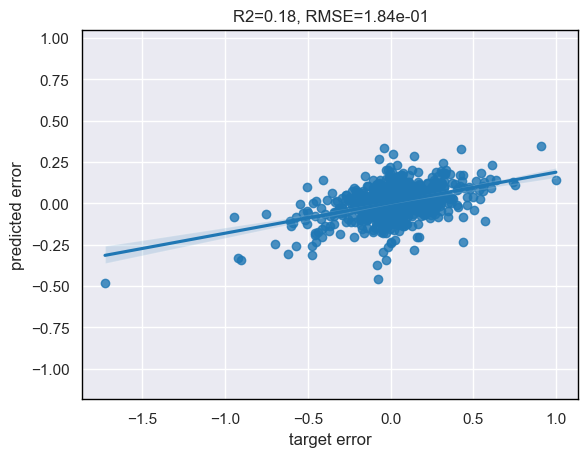

In [24]:
ax = scatter_plot (yval[:,20], ypredict[:,20])
ax.set_xlabel('target error')
ax.set_ylabel('predicted error');
ax.axis('equal');



There is a significant correlation between the target error and the predicted error (around 0.18), which is what we hoped for.
The neural network is supposed to learn the model error: if the analysis is used, the model error is estimated and therefore noisy because of the noise in the observation and the uncertainty of the analysis. So ideally, we don't aim at a correlation of 1, since it would mean that the neural network has fitted also the noise of the data. On the contrary, if the neural is trained using the *true* model error (`learning=truth`), you aim at the best possible correlation.

## <span style="color:blue"> V. On our way to part III  </span>

If you are under Colab or kaggle, click here to continue with part III: 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg) ](https://colab.research.google.com/github/marcbocquet/2022-mooc-ecmwf-bocquet-brajard/blob/main/mooc_ecmwf_bocquet_brajard_part3.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard/blob/main/mooc_ecmwf_bocquet_brajard_part3.ipynb)